## Visualization of the superpixel images, graphs and edge connections

In [1]:
from torchvision import datasets

import os
from scipy.spatial.distance import cdist
import numpy as np
from skimage.segmentation import mark_boundaries

import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import sys

os.chdir('../')
sys.path.append('./')
os.getcwd()
from prepare_dataset import compute_edges_list, process_image, compute_adjacency_matrix_images

### Prepare the dataset

In [2]:
dataset_name = 'mnist'
dataset_name = 'cifar10'
dataset_name = 'fashionmnist'
if dataset_name == 'mnist':
    dataset = datasets.MNIST(root='../dataset', train=True, download=False)
    classes = [str(i) for i in range(10)]
    n_sp = 75
    compactness = 0.25
    img_size = 28
elif dataset_name == 'cifar10':
    dataset = datasets.CIFAR10(root='../dataset', train=True, download=False)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    n_sp = 150
    compactness = 10
    img_size = 32
elif dataset_name == 'fashionmnist':
    dataset = datasets.FashionMNIST(root='../dataset', train=True, download=False)
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    n_sp = 75
    compactness = 0.3
    img_size = 28
images = dataset.data.numpy() if isinstance(dataset.data, torch.Tensor) else dataset.data
labels = dataset.targets

### Superpixels plot function definition

In [3]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams


def plot_superpixels_graph(plt, index, with_edges):

    p_intensity, sp_coord, _, _ = process_image((images[index], n_sp, compactness, True,index, dataset_name))
    label = labels[index]
    
    adj_matrix = compute_adjacency_matrix_images(sp_coord, p_intensity, True)
    Y = squareform(pdist(sp_coord, 'euclidean'))
    x_coord = sp_coord #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = p_intensity.mean(axis=1)
    label = classes[label]
    
    G = nx.from_numpy_array(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    title += " | Using feat and coord for knn"

    if not with_edges:
        title = "Label: " + str(label) + " | Only superpixel nodes"
    
    plt.title.set_text(title)
    
def show_image(plt, idx):
    x, label = images[idx], labels[idx] # x is now a torch.Tensor
    # img = x.numpy()[0]
    
    # x = x / 2 + 0.5 # unnormalize
    cmap = 'gray' if dataset_name == 'mnist' else None
    plt.imshow(x, cmap=cmap)

    plt.axis('off')
    plt.title.set_text("Label: " + str(classes[label]) + " | Original Image")
    
def plot_segmentation(plt, idx):
    _, _, _, superpixels = process_image((images[idx], n_sp, compactness, True,idx, dataset_name))
    label = labels[idx]
    cmap = 'gray' if dataset_name == 'mnist' else None
    
    plt.imshow(mark_boundaries(images[idx], superpixels), cmap = cmap)
    plt.axis('off')
    plt.title.set_text("Label: " + str(classes[label]) + " | Superpixels Segmentation")

### Plotting sample superpixels, and graphs

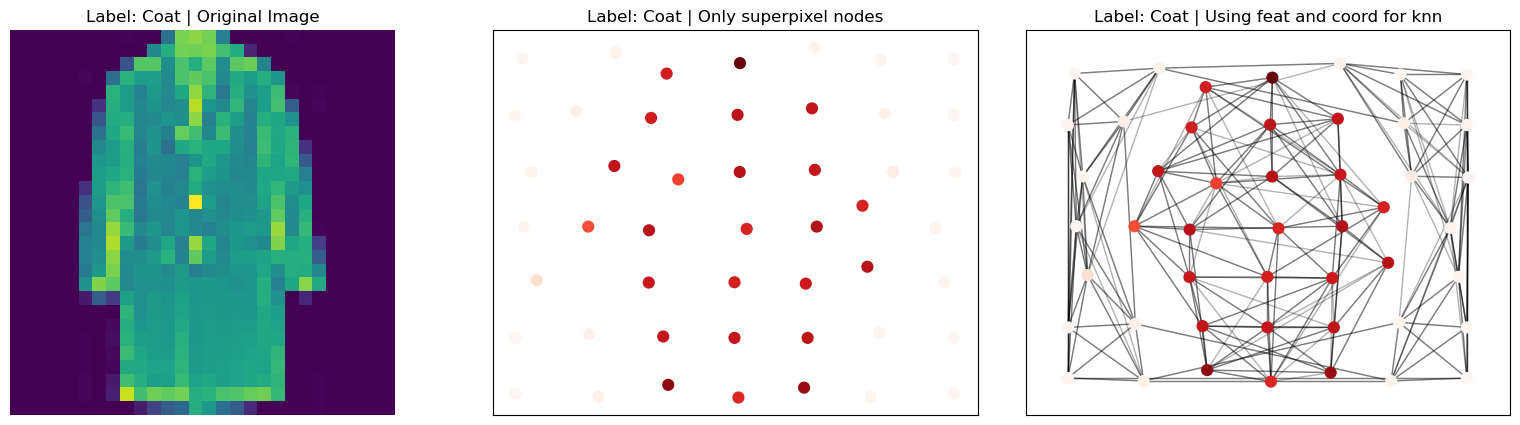

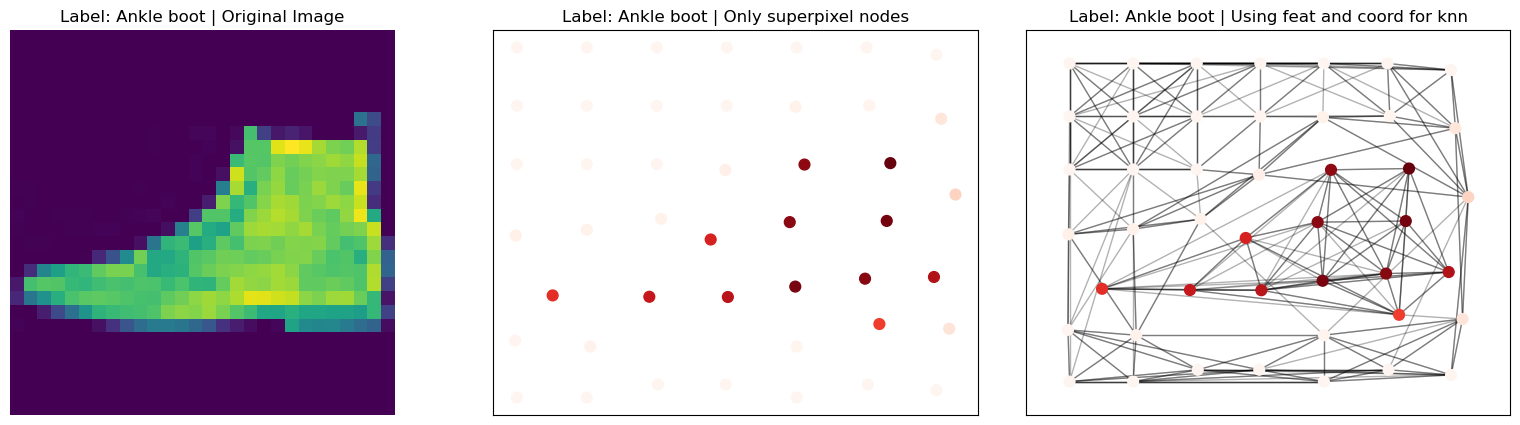

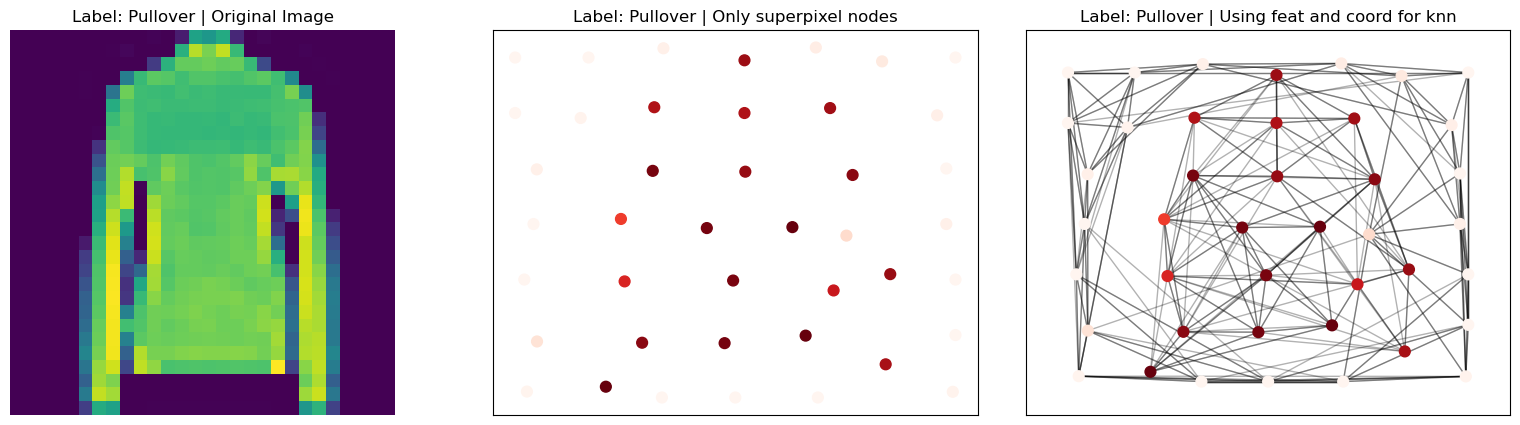

In [4]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(len(images), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(20, 5))
    
    plt1 = f.add_subplot(131)
    show_image(plt1, idx)
    
    plt2 = f.add_subplot(132)  
    plot_superpixels_graph(plt2, idx, with_edges=False)

    plt3 = f.add_subplot(133)
    plot_superpixels_graph(plt3, idx, with_edges=True)


    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    if not os.path.exists('./demo/superpixels_visualization'):
        os.makedirs('./demo/superpixels_visualization')
    # f.savefig('./demo/superpixels_visualization/'+ dataset_name + '_' +str(idx)+'.pdf', pad_inches=0, bbox_inches='tight')
    plt.show()